In [5]:
import os
import sys
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [6]:
cwd = os.getcwd()
# Find and import config file
config_path = os.getcwd()

sys.path.append(config_path)
import config

In [7]:
database = config.database
central_banks = config.central_banks
training_data = os.path.join(database, "Training Data")
fed_docs = config.fed_docs
ecb_docs = config.ecb_docs

In [8]:
url_map = pd.read_csv(os.path.join(cwd, "url_map.csv"))

for i in range(len(url_map)):
    if url_map["central bank"][i] == "fed" and url_map["document"][i] == "minutes":
        minutes = pd.read_csv(url_map["finbert_url"][i])

In [ ]:
sp500 = pd.read_csv(
    "/Users/kylenabors/Documents/Database/Market Data/SP500/SP500 Returns Daily.csv"
)

        date  minute_sentiment
0 1998-02-05                 0
1 1998-02-05                 0
2 1998-02-05                 0
3 1998-02-05                 0
4 1998-02-05                 0
date        1998-02-05  1998-04-02  1998-05-21  1998-07-02  1998-08-20  \
dup_number                                                               
1                  0.0         0.0         0.0         0.0         0.0   
2                  0.0         0.0         0.0         0.0         0.0   
3                  0.0         0.0         0.0         0.0         0.0   
4                  0.0         0.0         0.0         0.0         0.0   
5                  0.0         0.0         0.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
512                NaN         NaN         NaN         NaN         NaN   
513                NaN         NaN         NaN         NaN         NaN   
514                NaN         NaN         NaN         NaN         NaN   


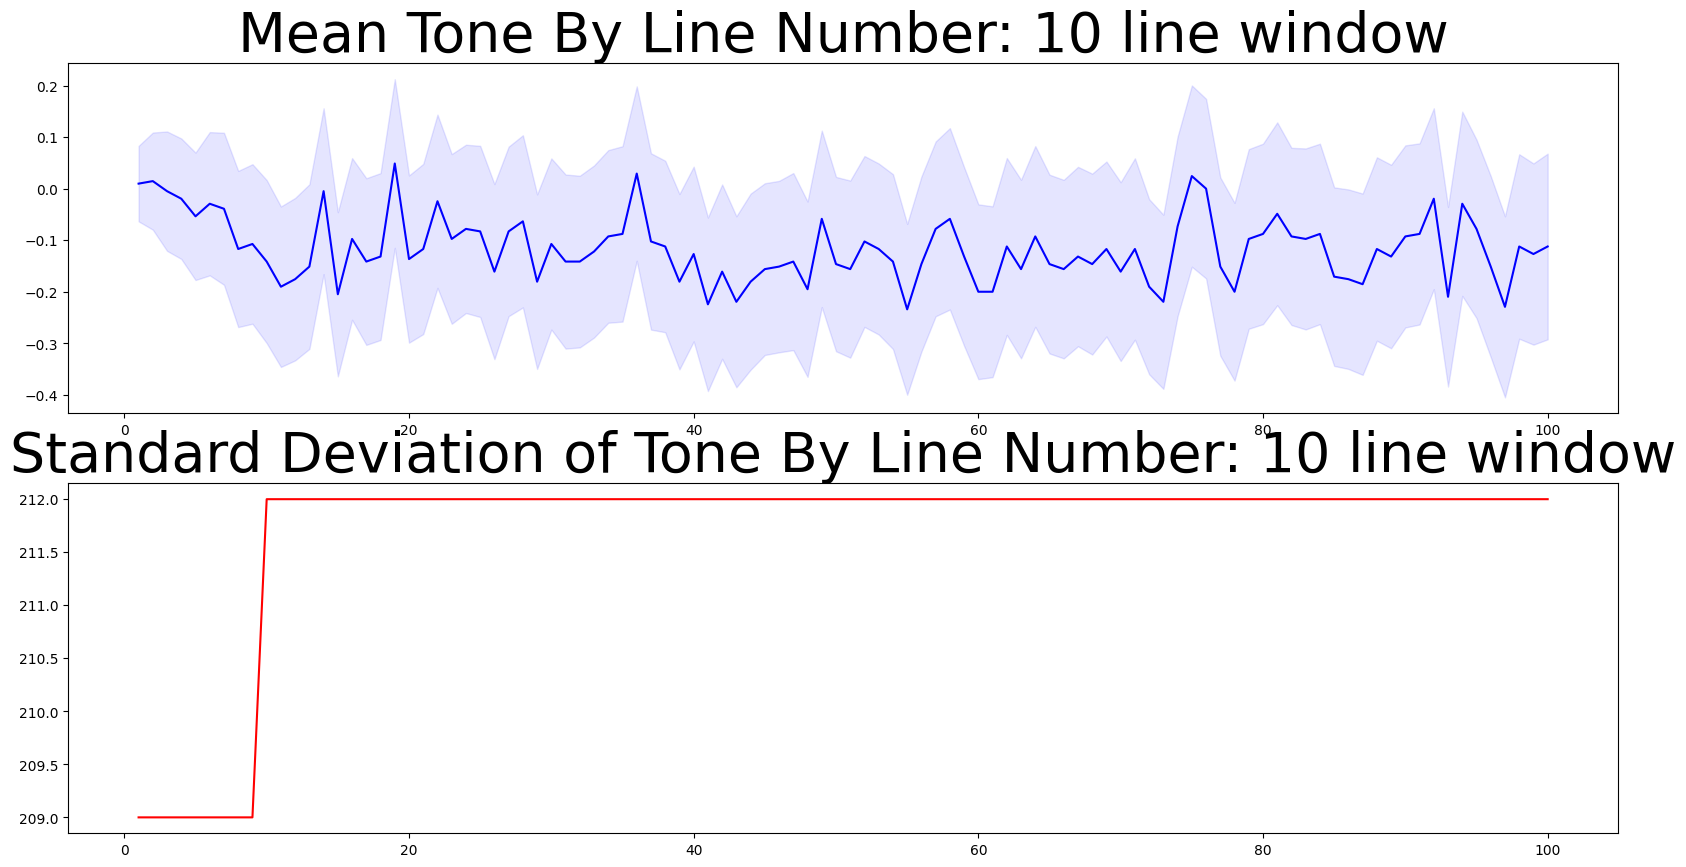

In [9]:
sp500 = sp500.rename(columns={"caldt": "date", "vwretd": "sp500_return"})
sp500["date"] = pd.to_datetime(sp500["date"])
minutes = minutes[["date", "sentiment"]]
minutes = minutes.rename(columns={"sentiment": "minute_sentiment"})
minutes["date"] = pd.to_datetime(minutes["date"])
minutes2 = minutes.copy(deep=True)
minutes = minutes.groupby("date").mean().reset_index()

filter_df = minutes.copy(deep=True)
filter_df = filter_df[["date", "minute_sentiment"]]

cycle, trend = sm.tsa.filters.hpfilter(
    filter_df["minute_sentiment"], 1600 * ((8 / 4) ** 4)
)

filter_df["minute_sentiment_cycle"] = cycle
filter_df["minute_sentiment_trend"] = trend

filter_df = filter_df[["date", "minute_sentiment_cycle"]]
minutes = minutes.drop(columns=["minute_sentiment"])
filter_df = filter_df.rename(columns={"minute_sentiment_cycle": "minute_sentiment"})
minutes = pd.merge(minutes, filter_df, on="date", how="left")
minutes = minutes.groupby("date").mean().reset_index()

event = range(len(minutes))
minutes["event"] = event
minutes = pd.merge(minutes, sp500, how="outer", on="date")

temp = minutes.copy(deep=True)
temp = temp[["event", "sp500_return"]]
temp["log_returns"] = np.log(temp["sp500_return"] + 1)
temp = temp[["event", "log_returns"]]
temp = temp.groupby("event").sum().reset_index()
minutes = minutes.groupby(minutes["event"]).mean().reset_index()

minutes = pd.merge(minutes, temp, how="left", left_on="event", right_on="event")

print(minutes2.head(5))

minutes2["dup_number"] = minutes2.groupby(["date"]).cumcount() + 1
pivot = pd.pivot_table(
    minutes2,
    index="dup_number",
    columns="date",
    values="minute_sentiment",
    fill_value=None,
)
print(pivot)

window = 10
pivot = pivot.iloc[:100]


pivot["mean"] = pivot.mean(axis=1)
pivot["var"] = pivot.var(axis=1)
pivot["sd"] = pivot["var"] ** 0.5
pivot["ci"] = 1.96 * np.sqrt(pivot["sd"] / len(pivot["sd"]))

pivot["rmean"] = pivot["mean"].rolling(window).mean()
pivot["rvar"] = pivot["mean"].rolling(window).var()
pivot["rsd"] = pivot["rvar"] ** 0.5
# pivot["ci"] = 1.96 * np.sqrt(pivot["rsd"] / len(pivot["rsd"]))


pivot["count"] = pivot.count(axis=1, numeric_only=True)

fig, axs = plt.subplots(2, 1, figsize=(20, 10))
axs[0].plot(pivot["mean"], color="blue", label="mean")
axs[0].fill_between(
    pivot.index,
    pivot["mean"] - pivot["ci"],
    pivot["mean"] + pivot["ci"],
    color="b",
    alpha=0.1,
)
axs[1].plot(pivot["count"], color="red", label="standard deviation")

axs[0].set_title(f"Mean Tone By Line Number: {window} line window", fontsize=40)
axs[1].set_title(
    f"Standard Deviation of Tone By Line Number: {window} line window", fontsize=40
)
plt.show()

pivot.to_csv("/Users/kylenabors/Downloads/pivot.csv")